In [1]:
from numpy import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datashader as ds
import astropy
print(astropy.__version__)
import healpy as hp
from astropy import units as u
from astropy.coordinates import SkyCoord
import plotly.express as px
import plotly.graph_objects as go

/var/folders/0d/3n4fgnc56j18ryg6n7s9jw341mfmjs/T/ipykernel_8994/927440755.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


5.3.4


In [2]:
# load Pelgrims (2020) dust model of Local Bubble
L19 = hp.read_map('/Users/dreardon/J0437-4715_mk_arcs/bubble/L19_map-inner_final.fits',field=3)
# convert to physical coordinates (Galactic x,y,z in pc with Sun at origin)
vec = asarray(hp.pix2vec(128,arange(hp.nside2npix(128))))
xyz_6pol = vec * L19
xl = xyz_6pol[0]
yl = xyz_6pol[1]
zl = xyz_6pol[2]

In [3]:
# XY plane (Z=0)
xy_x = xyz_6pol[0][abs(xyz_6pol[2])<.5]
xy_y = xyz_6pol[1][abs(xyz_6pol[2])<.5]

#YZ plane (X=0)
yz_y = xyz_6pol[1][abs(xyz_6pol[0])<1.5]
yz_z = xyz_6pol[2][abs(xyz_6pol[0])<1.5]

#XZ plane (Y=0)
xz_x = xyz_6pol[0][abs(xyz_6pol[1])<1.5]
xz_z = xyz_6pol[2][abs(xyz_6pol[1])<1.5]

In [4]:
### define pulsar & screen coordinates ### 

J0437_dist = 0.15679 # update distance if needed (kpc)

J0437_coord = SkyCoord(ra='04h37m15.896s',dec='-47d15m09.11s',distance=J0437_dist*u.kpc)

# array of screen distances
J0437_s = array([0.4874, 0.474, 0.4509, 0.3317, 0.331, 0.291, 0.268, 0.2484, 0.1889, 0.1506, 0.1495, 0.0904, 0.0893, 0.0812, 0.0685, 0.0238, 0.0235, 0.0158, 0.00468, 0.00346, 0.00119]) 
J0437_sdist = J0437_dist*(1. - J0437_s)
print('number of screens = ',len(J0437_sdist))

# define screen locations in sky coordinates
J0437_scoord = SkyCoord(['+4h37m15.896s -47d15m09.11s']*len(J0437_s),
                        unit=(u.hourangle, u.deg), distance=J0437_sdist*u.kpc)

# screen locations in Galactic Cartesian (heliocentric) coordinates
J0437_scoordx = J0437_scoord.galactic.cartesian.x.value
J0437_scoordy = J0437_scoord.galactic.cartesian.y.value
J0437_scoordz = J0437_scoord.galactic.cartesian.z.value

number of screens =  21


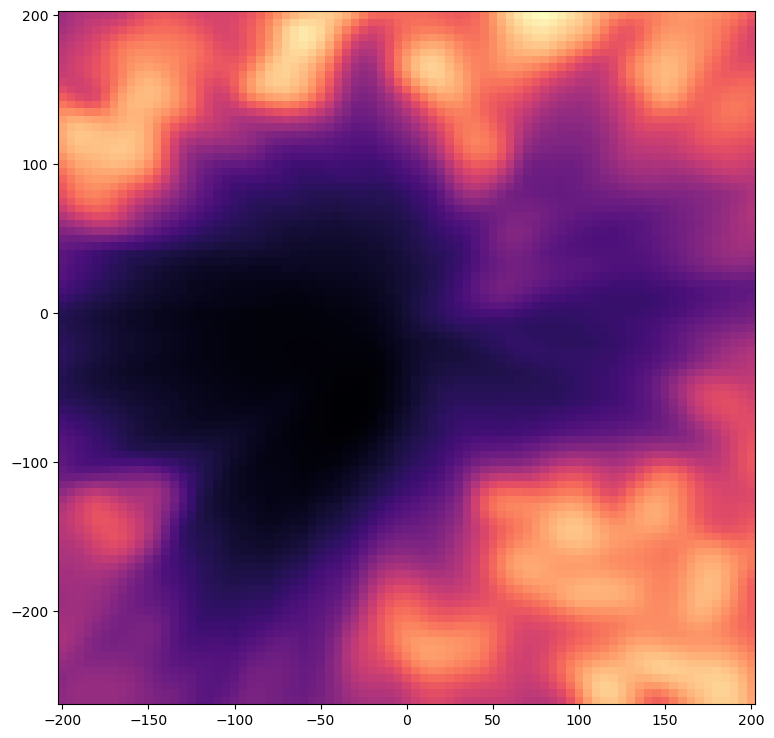

In [5]:
# XY
data = np.load('/Users/dreardon/J0437-4715_mk_arcs/bubble/STILISM_XY.npz')

X = data['X']
Y = data['Y']
E = data['E']

xind = np.argwhere(np.abs(X) <= 200).squeeze()
yind = np.argwhere(Y <= 200).squeeze()

Xnew = X[xind].squeeze()
Ynew = Y[yind].squeeze()
Enew = E[yind, :].squeeze()[:, xind].squeeze()

yind = np.argwhere(np.abs(Ynew) <= 260).squeeze()
Enew = Enew[yind, :].squeeze()

Ynew = Ynew[yind].squeeze()


plt.figure(figsize=(9, 9))
plt.pcolormesh(Xnew, Ynew, np.log(Enew), shading='nearest', cmap='magma')
plt.show()

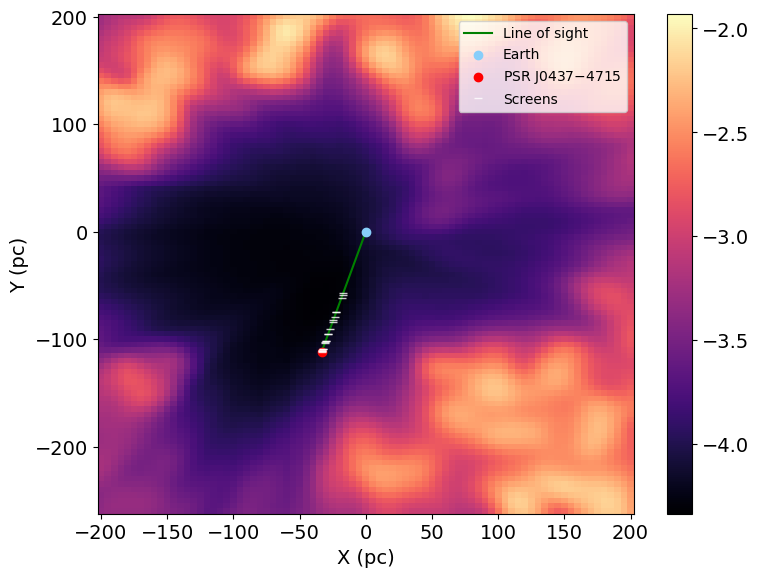

In [10]:
from matplotlib import rc
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
rc('text', usetex=False)
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rcParams.update({'font.size': 14})

# a simple matplotlib version
fig = plt.figure(figsize=(8,6))
plt.pcolormesh(Xnew, Ynew, np.log10(Enew), shading='nearest', cmap='magma',linewidth=0,rasterized=True)#, vmax=-9)
plt.colorbar()
# plt.plot(xy_x[::10], xy_y[::10],'--',color='w',label='Local Bubble')
plt.plot([0,J0437_coord.galactic.cartesian.x.value*1000],[0,J0437_coord.galactic.cartesian.y.value*1000],color='green',
        label='Line of sight')
plt.scatter(0,0,color='lightskyblue',label='Earth', zorder=10)
plt.scatter(J0437_coord.galactic.cartesian.x.value*1000,J0437_coord.galactic.cartesian.y.value*1000,color='r',label='PSR J0437$-$4715', zorder=10)
plt.plot(J0437_scoordx*1000,J0437_scoordy*1000,'_', color='w',alpha=0.8,ms=6,label='Screens', zorder=11)
plt.legend(loc='upper right', fontsize=10)
plt.xlabel('X (pc)')
plt.ylabel('Y (pc)')
#plt.axis('equal')
plt.tight_layout()
plt.savefig('bubble.pdf')
plt.show()

In [7]:
# defining some colors
prism_colors= px.colors.qualitative.Prism
#plotly_colors = px.colors.qualitative.Plotly
pastel_colors = px.colors.qualitative.Pastel1
plotly_colors = px.colors.qualitative.Dark24

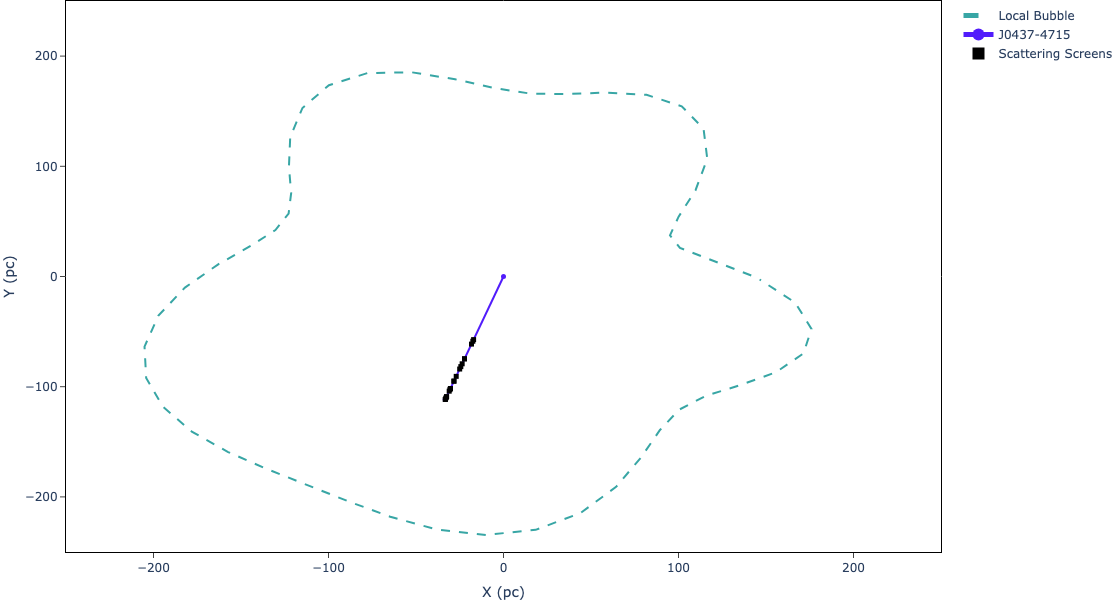

In [33]:
fig = go.Figure()

### FIGURE DATA ###

# Local Bubble 
fig.add_trace(go.Scatter(x=xy_x[::10], y=xy_y[::10],
                           line=dict(dash='dash',color=prism_colors[2]),name='Local Bubble')) # use 0.03 opacity for zoom figure

# spoke for J0437
fig.add_trace(go.Scatter(x=[0,J0437_coord.galactic.cartesian.x.value*1000],y=[0,J0437_coord.galactic.cartesian.y.value*1000],
                           marker=dict(color=plotly_colors[9],size=5,opacity=1),
                           line=dict(color=plotly_colors[9],width=2),name='J0437-4715'))

# screen locations for J0437
fig.add_trace(go.Scatter(x=J0437_scoordx*1000,y=J0437_scoordy*1000,mode='markers',
                           marker_symbol='square',marker=dict(color='black',size=5),name='Scattering Screens',
                           showlegend=True))

### FIGURE LAYOUT ###

# update range=[-300,300] for x and y axis range
fig.update_layout(
        xaxis = dict(range=[-250,250],showticklabels=True),
        yaxis = dict(range=[-250,250],showticklabels=True),
        xaxis_title='X (pc)',
        yaxis_title='Y (pc)',
        width=900,
        height=600,
        margin = {'l':0,'r':0,'t':0,'b':0})

fig.update_layout(legend={'itemsizing':'constant'})
fig.update_layout(plot_bgcolor='white')

fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black'
)
fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black'
)

### SHOW/SAVE IMAGE ###

#fig.write_image('J0437_LOS.pdf',scale=0.1) # save figure as pdf
fig.show()

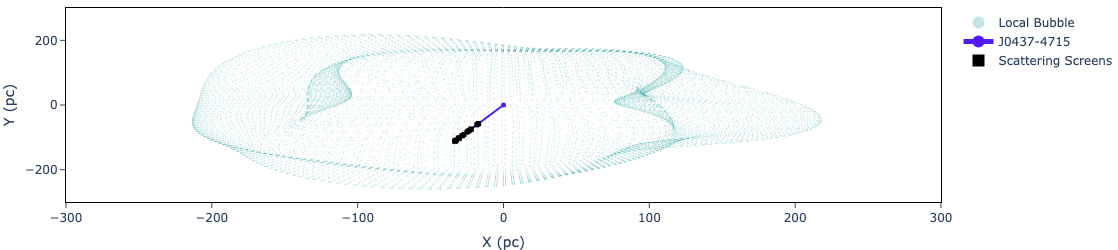

In [9]:
# version where the Local Bubble is shaded instead of unfilled line (larger file size)
fig = go.Figure()

### FIGURE DATA ###

# Local Bubble 
fig.add_trace(go.Scatter(x=xl[::10], y=yl[::10],mode='markers',
                           marker=dict(size=1,color=prism_colors[2],opacity=0.3),name='Local Bubble')) # use 0.03 opacity for zoom figure

# spoke for J0437
fig.add_trace(go.Scatter(x=[0,J0437_coord.galactic.cartesian.x.value*1000],y=[0,J0437_coord.galactic.cartesian.y.value*1000],
                           marker=dict(color=plotly_colors[9],size=5,opacity=1),
                           line=dict(color=plotly_colors[9],width=2),name='J0437-4715'))

# screen locations for J0437
fig.add_trace(go.Scatter(x=J0437_scoordx*1000,y=J0437_scoordy*1000,mode='markers',
                           marker_symbol='square',marker=dict(color='black',size=5),name='Scattering Screens',
                           showlegend=True))

### FIGURE LAYOUT ###

# update range=[-300,300] for x and y
fig.update_layout(
        xaxis = dict(range=[-300,300],showticklabels=True),
        yaxis = dict(range=[-300,300],showticklabels=True),
        xaxis_title='X (pc)',
        yaxis_title='Y (pc)',
        width=450,
        height=250,
        margin = {'l':0,'r':0,'t':0,'b':0})

fig.update_layout(legend={'itemsizing':'constant'})
fig.update_layout(plot_bgcolor='white')

fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black'
)
fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black'
)

### SHOW/SAVE IMAGE ###

#fig.write_image('J0437_LOS.pdf',scale=0.1) # save figure as pdf
fig.show()